In [1]:
import numpy as np
import pandas as pd
from typing import Mapping, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
    load_breast_cancer, load_diabetes, fetch_mldata
from  matplotlib.collections import LineCollection
import time
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from pdpbox import pdp
from rfpimp import *
from scipy.integrate import cumtrapz
# from stratx.plot import *
# from stratx.ice import *

%config InlineBackend.figure_formats = ['png']

def df_string_to_cat(df:pd.DataFrame) -> dict:
    catencoders = {}
    for colname in df.columns:
        if is_string_dtype(df[colname]) or is_object_dtype(df[colname]):
            df[colname] = df[colname].astype('category').cat.as_ordered()
            catencoders[colname] = df[colname].cat.categories
    return catencoders


def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

In [2]:
def load_rent():
    """
    *Data use rules prevent us from storing this data in this repo*. Download the data
    set from Kaggle. (You must be a registered Kaggle user and must be logged in.)
    Go to the Kaggle [data page](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data)
    and save `train.json`
    :return:
    """
    df = pd.read_json('data/train.json')

    # Create ideal numeric data set w/o outliers etc...
    df = df[(df.price > 1_000) & (df.price < 10_000)]
    df = df[df.bathrooms <= 4]  # There's almost no data for above with small sample
    df = df[(df.longitude != 0) | (df.latitude != 0)]
    df = df[(df['latitude'] > 40.55) & (df['latitude'] < 40.94) &
            (df['longitude'] > -74.1) & (df['longitude'] < -73.67)]
    df = df.sort_values('created')
    df_rent = df[['bedrooms', 'bathrooms', 'latitude', 'longitude', 'price']]

    return df_rent

In [3]:
def leaf_samples(rf, X:np.ndarray):
    """
    Return a list of arrays where each array is the set of X sample indexes
    residing in a single leaf of some tree in rf forest.
    """
    ntrees = len(rf.estimators_)
    leaf_ids = rf.apply(X) # which leaf does each X_i go to for each tree?
    d = pd.DataFrame(leaf_ids, columns=[f"tree{i}" for i in range(ntrees)])
    d = d.reset_index() # get 0..n-1 as column called index so we can do groupby
    """
    d looks like:
        index	tree0	tree1	tree2	tree3	tree4
    0	0	    8	    3	    4	    4	    3
    1	1	    8	    3	    4	    4	    3
    """
    leaf_samples = []
    for i in range(ntrees):
        """
        Each groupby gets a list of all X indexes associated with same leaf. 4 leaves would
        get 4 arrays of X indexes; e.g.,
        array([array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([10, 11, 12, 13, 14, 15]), array([16, 17, 18, 19, 20]),
               array([21, 22, 23, 24, 25, 26, 27, 28, 29]), ... )
        """
        sample_idxs_in_leaf = d.groupby(f'tree{i}')['index'].apply(lambda x: x.values)
        leaf_samples.extend(sample_idxs_in_leaf) # add [...sample idxs...] for each leaf
    return leaf_samples

In [96]:
df_rent = load_rent()
df_rent = df_rent[-10_000:]  # get a small subsample since SVM is slowwww
df_rent['latitude'] = (df_rent['latitude']-40)*100 # shift so easier to read
df_rent.head(3)

X = df_rent.drop('price', axis=1)
y = df_rent['price']

# New continuous version

In [35]:
def collect_point_betas(X, y, colname, leaves, nbins):
    point_betas = np.full(shape=(len(X),), fill_value=np.nan)
    for samples in leaves: # samples is set of obs indexes that live in a single leaf
        leaf_all_x = X.iloc[samples]
        leaf_x = leaf_all_x[colname].values
        leaf_y = y.iloc[samples].values
        # Right edge of last bin is max(leaf_x) but that means we ignore the last value
        # every time. Tweak domain right edge a bit so max(leaf_x) falls in last bin.
        last_bin_extension = 0.0000001
        domain = (np.min(leaf_x), np.max(leaf_x)+last_bin_extension)
        bins = np.linspace(*domain, num=nbins+1, endpoint=True)
#         print('bins', bins)
        binned_idx = np.digitize(leaf_x, bins) # bin number for values in leaf_x
#         print(leaf_x, '->', leaf_y)
#         print(f"leaf samples: {samples}, binned_idx: {binned_idx}")
        for b in range(1, len(bins)+1):
            bin_x = leaf_x[binned_idx == b]
            bin_y = leaf_y[binned_idx == b]
            bin_obs_idx = np.digitize(bin_x, bins) # bin number for values in leaf_x
            if len(bin_x)<2: # either no or too little data
    #             print(f'ignoring {bin_x} -> {bin_y}')
                continue
            r = (np.min(bin_x), np.max(bin_x))
            if np.isclose(r[0], r[1]):
    #             print(f'ignoring {bin_x} -> {bin_y} for same range')
                continue
            lm = LinearRegression()
    #         bin_x = bin_x.reshape(-1, 1)
            leaf_obs_idx_for_bin = np.nonzero((leaf_x>=bins[b-1]) &(leaf_x<bins[b]))
            leaf_x_in_bin = leaf_x[leaf_obs_idx_for_bin]
            obs_idx = samples[leaf_obs_idx_for_bin]
#             print("\tx in range", leaf_x_in_bin, leaf_obs_idx_for_bin, "obs idx", obs_idx)
            lm.fit(bin_x.reshape(-1, 1), bin_y)
#             print(f'\tbin{b}', bin_x, '->', bin_y, 'beta', lm.coef_[0])
            point_betas[obs_idx] = lm.coef_[0]
    return point_betas

def foo(X, y, colname, ntrees = 1, min_samples_leaf=10, bootstrap=False, max_features=1.0, nbins=2):
    rf = RandomForestRegressor(n_estimators=ntrees,
                               min_samples_leaf=min_samples_leaf,
                               bootstrap = bootstrap,
                               max_features = max_features)
    rf.fit(X.drop(colname, axis=1), y)
    print(rf)
    leaves = leaf_samples(rf, X.drop(colname, axis=1))
    nnodes = rf.estimators_[0].tree_.node_count
    print(f"Partitioning 'x not {colname}': {nnodes} nodes in (first) tree, "
          f"{len(rf.estimators_)} trees, {len(leaves)} total leaves")

    point_betas = collect_point_betas(X, y, colname, leaves, nbins)
    Xbetas = np.vstack([X[colname].values, point_betas]).T # get x_c, beta matrix
    Xbetas = Xbetas[Xbetas[:,0].argsort()] # sort by x coordinate
    return Xbetas

In [83]:
Xbetas = foo(X, y, 'bedrooms', nbins=3)
Xbetas#[0:30]

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=1.0, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Partitioning 'x not bedrooms': 1397 nodes in (first) tree, 1 trees, 699 total leaves


array([[ 0., nan],
       [ 0., nan],
       [ 0., nan],
       ...,
       [ 6., nan],
       [ 8., nan],
       [ 8., nan]])

In [84]:
np.unique(Xbetas[:,0])

array([0., 1., 2., 3., 4., 5., 6., 8.])

In [85]:
for x in np.unique(Xbetas[:,0]):
    print(x, np.nanmean(Xbetas[Xbetas[:,0]==x]))

0.0 152.344832005553
1.0 155.87508868346092
2.0 71.9649688917843
3.0 44.208150974109884
4.0 99.87234524559666
5.0 206.21394230769232
6.0 136.5
8.0 8.0


In [86]:
nbins_smoothing = 9
x = Xbetas[:,0]
#slopes = Xbetas[:,1]
domain = (np.min(x), np.max(x)) # ignores any max(x) points as no slope info after that
bins_smoothing = np.linspace(*domain, num=nbins_smoothing+1, endpoint=True)
# or use all unique values as bin edges
bins_smoothing = np.array(sorted(np.unique(x)))
binned_idx = np.digitize(x, bins_smoothing) # bin number for values in leaf_x

noinfo = np.isnan(Xbetas[:,1])
Xbetas = Xbetas[~noinfo]

from scipy.stats import binned_statistic
avg_slopes_per_bin, _, _ = binned_statistic(x=Xbetas[:,0], values=Xbetas[:,1], bins=bins_smoothing, statistic='mean')
# avg_slopes_per_bin might have nan for empty bins
bin_deltas = np.diff(bins_smoothing)
print('bins_smoothing', bins_smoothing, ', deltas', bin_deltas)
avg_slopes_per_bin *= bin_deltas
print('avgslopes', avg_slopes_per_bin)
curve = np.nancumsum(avg_slopes_per_bin)
curve = np.concatenate([np.array([0]), curve])  # we start at 0 for min(x)
print('curve cumsum   ', curve)

bins_smoothing [0. 1. 2. 3. 4. 5. 6. 8.] , deltas [1. 1. 1. 1. 1. 1. 2.]
avgslopes [ 556.572041    554.19561065  897.66265732  460.90036292  577.92075168
  876.92708333 2100.        ]
curve cumsum    [   0.          556.572041   1110.76765165 2008.43030897 2469.33067189
 3047.25142357 3924.1785069  6024.1785069 ]


  0.0,  0.0,  0.0
  1.0,556.6,556.6
  2.0,1110.8,554.2
  3.0,2008.4,897.7
  4.0,2469.3,460.9
  5.0,3047.3,577.9
  6.0,3924.2,876.9
  8.0,6024.2,2100.0


[(0.0, 0.0),
 (1.0, 556.5720409996544),
 (2.0, 1110.7676516505858),
 (3.0, 2008.4303089716036),
 (4.0, 2469.3306718937056),
 (5.0, 3047.2514235694007),
 (6.0, 3924.178506902734),
 (8.0, 6024.178506902734)]

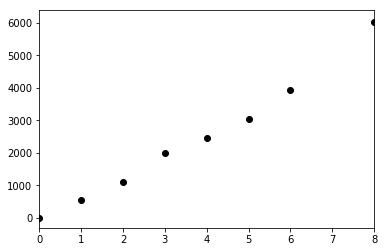

In [87]:
# manual cumsum (not needed)
plot_x = []
plot_y = []
cumslope = 0.0
avg_slopes_per_bin = np.concatenate([np.array([0]), avg_slopes_per_bin])  # we start at 0 for min(x)
for x,slope in zip(bins_smoothing,avg_slopes_per_bin):
    if np.isnan(slope):
        print(f"{x:5.1f},{cumslope:5.1f},{slope:5.1f} SKIP")
        continue
    cumslope += slope
    plot_x.append(x)
    plot_y.append(cumslope)
    print(f"{x:5.1f},{cumslope:5.1f},{slope:5.1f}")
    plt.scatter([x],[cumslope], c='black')
plt.xlim(0,8)
list(zip(plot_x,plot_y))

has_slope_info (array([0, 1, 2, 3, 4, 5, 6, 8]),) no slope (array([], dtype=int64),)
bins      [0.         0.88888889 1.77777778 2.66666667 3.55555556 4.44444444
 5.33333333 7.11111111]
curve [   0.          502.35204079  983.9339238  1506.12521557 1922.18298776
 2480.63976754 3420.57549739 3835.48907763]


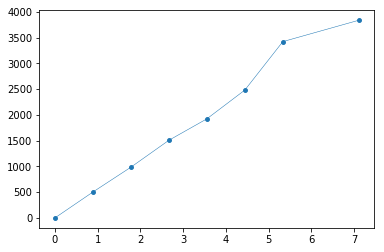

In [76]:
has_slope_info = np.nonzero(~np.isnan(avg_slopes_per_bin))
print('has_slope_info', has_slope_info, 'no slope', np.nonzero(np.isnan(curve)))
print('bins     ', bins_smoothing[has_slope_info])
print('curve', curve[has_slope_info])

bins_smoothing = bins_smoothing[has_slope_info]
curve = curve[has_slope_info]

plt.scatter(bins_smoothing, curve, s=15)
plt.plot(bins_smoothing, curve, lw=.5)
#plt.ylim(0,4000)

# New binned continuous version

In [92]:
def collect_bin_betas(X, y, colname, leaves, nbins):
    point_betas = np.full(shape=(len(X),), fill_value=np.nan)
    for samples in leaves: # samples is set of obs indexes that live in a single leaf
        leaf_all_x = X.iloc[samples]
        leaf_x = leaf_all_x[colname].values
        leaf_y = y.iloc[samples].values
        # Right edge of last bin is max(leaf_x) but that means we ignore the last value
        # every time. Tweak domain right edge a bit so max(leaf_x) falls in last bin.
        last_bin_extension = 0.0000001
        domain = (np.min(leaf_x), np.max(leaf_x)+last_bin_extension)
        bins = np.linspace(*domain, num=nbins+1, endpoint=True)
#         print('bins', bins)
        binned_idx = np.digitize(leaf_x, bins) # bin number for values in leaf_x
#         print(leaf_x, '->', leaf_y)
#         print(f"leaf samples: {samples}, binned_idx: {binned_idx}")
        for b in range(1, len(bins)+1):
            bin_x = leaf_x[binned_idx == b]
            bin_y = leaf_y[binned_idx == b]
            bin_obs_idx = np.digitize(bin_x, bins) # bin number for values in leaf_x
            if len(bin_x)<2: # either no or too little data
    #             print(f'ignoring {bin_x} -> {bin_y}')
                continue
            r = (np.min(bin_x), np.max(bin_x))
            if np.isclose(r[0], r[1]):
    #             print(f'ignoring {bin_x} -> {bin_y} for same range')
                continue
            lm = LinearRegression()
    #         bin_x = bin_x.reshape(-1, 1)
            leaf_obs_idx_for_bin = np.nonzero((leaf_x>=bins[b-1]) &(leaf_x<bins[b]))
            leaf_x_in_bin = leaf_x[leaf_obs_idx_for_bin]
            obs_idx = samples[leaf_obs_idx_for_bin]
#             print("\tx in range", leaf_x_in_bin, leaf_obs_idx_for_bin, "obs idx", obs_idx)
            lm.fit(bin_x.reshape(-1, 1), bin_y)
#             print(f'\tbin{b}', bin_x, '->', bin_y, 'beta', lm.coef_[0])
            point_betas[obs_idx] = lm.coef_[0]
    return point_betas

In [93]:
#def nouveau(X, y, colname, ntrees = 1, min_samples_leaf=10, bootstrap=False, max_features=1.0, nbins=2):
rf = RandomForestRegressor(n_estimators=ntrees,
                           min_samples_leaf=min_samples_leaf,
                           bootstrap = bootstrap,
                           max_features = max_features)
rf.fit(X.drop(colname, axis=1), y)
print(rf)
leaves = leaf_samples(rf, X.drop(colname, axis=1))
nnodes = rf.estimators_[0].tree_.node_count
print(f"Partitioning 'x not {colname}': {nnodes} nodes in (first) tree, "
      f"{len(rf.estimators_)} trees, {len(leaves)} total leaves")

bin_betas = np.full(shape=(len(X),), fill_value=np.nan)
for samples in leaves: # samples is set of obs indexes that live in a single leaf
    leaf_all_x = X.iloc[samples]
    leaf_x = leaf_all_x[colname].values
    leaf_y = y.iloc[samples].values
    # Right edge of last bin is max(leaf_x) but that means we ignore the last value
    # every time. Tweak domain right edge a bit so max(leaf_x) falls in last bin.
    last_bin_extension = 0.0000001
    domain = (np.min(leaf_x), np.max(leaf_x)+last_bin_extension)
    bins = np.linspace(*domain, num=nbins+1, endpoint=True)
#         print('bins', bins)
    binned_idx = np.digitize(leaf_x, bins) # bin number for values in leaf_x
#         print(leaf_x, '->', leaf_y)
#         print(f"leaf samples: {samples}, binned_idx: {binned_idx}")
    for b in range(1, len(bins)+1):
        bin_x = leaf_x[binned_idx == b]
        bin_y = leaf_y[binned_idx == b]
        bin_obs_idx = np.digitize(bin_x, bins) # bin number for values in leaf_x

In [94]:
Xbetas = nouveau(X, y, 'latitude', nbins=3)
Xbetas#[0:30]

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=1.0, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Partitioning 'x not latitude': 1383 nodes in (first) tree, 1 trees, 692 total leaves


# New discrete

In [166]:
# fake
# df_rent = pd.DataFrame()
# df_rent['bedrooms'] = np.array([1,1, 2,2,   3, 9,9])
# df_rent['price'] = np.array([5,5, 6,6.4, 9, 7,7.2])
# X = df_rent.drop('price', axis=1)
# y = df_rent['price']
# df_rent

In [348]:
df_rent = load_rent()
df_rent = df_rent[-50:]  # get a small subsample since SVM is slowwww
df_rent['latitude'] = (df_rent['latitude']-40)*100 # shift so easier to read
df_rent.head(3)
X = df_rent.drop('price', axis=1)
y = df_rent['price']

In [342]:
colname='bedrooms'
rf = RandomForestRegressor(n_estimators=1,
                           min_samples_leaf=10,
                           bootstrap = False,
                           max_features = 1.0)
rf.fit(X.drop(colname, axis=1), y)
leaves = leaf_samples(rf, X.drop(colname, axis=1))
nnodes = rf.estimators_[0].tree_.node_count
print(f"Partitioning 'x not {colname}': {nnodes} nodes in (first) tree, "
      f"{len(rf.estimators_)} trees, {len(leaves)} total leaves")

leaf_slopes = []
leaf_xranges = []
maxx = max(X[colname])
bin_betas = np.full(shape=(maxx+1,len(leaves)), fill_value=np.nan)
bin_counts = np.zeros(shape=(maxx+1,len(leaves)))
for li,samples in enumerate(leaves): # samples is set of obs indexes that live in a single leaf
    leaf_all_x = X.iloc[samples]
    leaf_x = leaf_all_x[colname].values
    leaf_y = y.iloc[samples].values

    bcount = np.bincount(leaf_x)
    bsum = np.bincount(leaf_x, weights=leaf_y) # sum ys for each values of x
    binavgs = bsum / bcount
    bins = np.nonzero(bsum)[0]
    binavgs = binavgs[bins]
#     print()
#     print('leaf_x',list(leaf_x))
#     print('bcount',bcount)
#     print('bsum',bsum)
#     print('bins', bins)
#     print('binavgs',binavgs)

    bin_deltas = np.diff(bins)
    y_deltas = np.diff(binavgs)
    leaf_bin_slopes = y_deltas / bin_deltas  # "rise over run"
    leaf_slopes.extend(leaf_bin_slopes)
    print('leaf_bin_slopes', leaf_bin_slopes)
    leaf_bin_xranges = np.array(list(zip(bins, bins[1:])))
    print('leaf_bin_xranges',leaf_bin_xranges)
    leaf_xranges.extend(leaf_bin_xranges)
#     print('bin_deltas',bin_deltas)
#     print('y_deltas', y_deltas)
#     print('leaf_slopes',leaf_slopes)
#     print(leaf_xranges)
    leaf_betas = np.full(shape=(maxx+1,), fill_value=np.nan)
    leaf_betas[bins[:-1]] = leaf_bin_slopes
    bin_betas[:,li] = leaf_betas
    leaf_counts = np.zeros(shape=(maxx+1,))
    leaf_counts[bins] = bcount[bins]
    bin_counts[:,li] = leaf_counts
# print('bin_betas', bin_betas)
# print('bin_counts', bin_counts)
print('leaf_slopes',leaf_slopes)
print('leaf_xranges',leaf_xranges)

Partitioning 'x not bedrooms': 7 nodes in (first) tree, 1 trees, 4 total leaves
leaf_bin_slopes [1706.42857143  191.9047619   106.66666667 1845.        ]
leaf_bin_xranges [[0 1]
 [1 2]
 [2 3]
 [3 4]]
leaf_bin_slopes [1073.0952381  3477.32142857 -775.41666667]
leaf_bin_xranges [[0 1]
 [1 2]
 [2 3]]
leaf_bin_slopes [529.33333333 199.5       ]
leaf_bin_xranges [[0 1]
 [1 3]]
leaf_bin_slopes [1496.66666667 -673.33333333 1323.        ]
leaf_bin_xranges [[0 1]
 [1 2]
 [2 3]]
leaf_slopes [1706.4285714285716, 191.90476190476193, 106.66666666666652, 1845.0, 1073.095238095238, 3477.3214285714284, -775.416666666667, 529.3333333333335, 199.5, 1496.6666666666665, -673.333333333333, 1323.0]
leaf_xranges [array([0, 1]), array([1, 2]), array([2, 3]), array([3, 4]), array([0, 1]), array([1, 2]), array([2, 3]), array([0, 1]), array([1, 3]), array([0, 1]), array([1, 2]), array([2, 3])]


In [312]:
bin_betas

array([[1706.42857143, 1073.0952381 ,  529.33333333, 1496.66666667],
       [ 191.9047619 , 3477.32142857,  199.5       , -673.33333333],
       [ 106.66666667, -775.41666667,           nan, 1323.        ],
       [1845.        ,           nan,           nan,           nan],
       [          nan,           nan,           nan,           nan]])

In [336]:
avg_slopes_per_bin = np.nanmean(bin_betas, axis=1)

pdpx = np.arange(0,maxx+1)

avg_slopes_per_bin_ = np.concatenate([np.array([0]), avg_slopes_per_bin[:-1]]) # drop last one and put 0 at front
print(avg_slopes_per_bin_)
plot_y = []
cumslope = 0.0
for x, slope in zip(pdpx, avg_slopes_per_bin_):
    if np.isnan(slope):
        print(f"{x:5.3f},{cumslope:5.1f},{slope:5.1f} SKIP")
        continue
    cumslope += slope
    plot_y.append(cumslope)
    print(f"{x:5.3f},{cumslope:5.1f},{slope:5.1f}")
print(plot_y)

[   0.         1201.38095238  798.84821429  218.08333333 1845.        ]
0.000,  0.0,  0.0
1.000,1201.4,1201.4
2.000,2000.2,798.8
3.000,2218.3,218.1
4.000,4063.3,1845.0
[0.0, 1201.3809523809523, 2000.2291666666665, 2218.3124999999995, 4063.3124999999995]


([<matplotlib.axis.XTick at 0x1a4749ef98>,
 <a list of 5 Text xticklabel objects>)

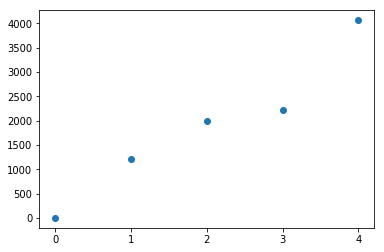

In [334]:
plt.scatter(pdpx, plot_y)
plt.xticks(pdpx)

## ugh, can't use floats for discrete, try groupby again?

In [372]:
df_rent = load_rent()
df_rent = df_rent[-100:]  # get a small subsample since SVM is slowwww
#df_rent['latitude'] = (df_rent['latitude']-40)*100 # shift so easier to read

colname = 'bathrooms'
xy = pd.concat([df_rent[colname], df_rent['price']], axis=1)

xy.columns = ['x', 'y']
xy.head(5)

,x,y
11649,1.0,3995
20831,1.0,2700
3294,2.0,4300
37112,1.0,2150
35982,1.0,2350


In [373]:
df_avg = xy.groupby('x').mean().reset_index()
x = df_avg['x'].values
y = df_avg['y'].values
# wack one
#df_avg.iloc[3,:] = [3,np.nan]
df_avg

,x,y
0,1.0,3148.011364
1,2.0,5176.636364
2,3.5,5495.000000


In [380]:
uniq_x = x
bin_deltas = np.diff(uniq_x)
y_deltas = np.diff(y)
leaf_slopes = y_deltas / bin_deltas  # "rise over run"
leaf_xranges = np.array(list(zip(uniq_x, uniq_x[1:])))
leaf_sizes = xy['x'].value_counts().sort_index().values

In [379]:
bin_deltas

array([1. , 1.5])

In [376]:
leaf_xranges

array([[1. , 2. ],
       [2. , 3.5]])

In [377]:
leaf_slopes

array([2028.625     ,  212.24242424])

In [378]:
y_deltas

array([2028.625     ,  318.36363636])